<a href="https://colab.research.google.com/github/xxFirefly/CycleGAN/blob/master/myCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Чего только уже не делал с этим кодом, но увы так и не заработало. Даже генератор работает странно, плохо передает цвета, обычно они все словно в тумане. Голубое небо становится серым:/

## Install

In [1]:
# for augmentations
!pip install -U albumentations

# for pretrained models for PyTorch
!pip install pretrainedmodels


################
# Catalyst itself
!pip install -U catalyst
# For specific version of catalyst, uncomment:
# ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}
################

# for TTA
# !pip install ttach

# for tensorboard
!pip install tensorflow
%load_ext tensorboard

# for alchemy experiment logging integration, uncomment this 2 lines below
# !pip install -U alchemy
# is_alchemy_used = True

is_fp16_used = False
# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True

#!pip install --upgrade efficientnet-pytorch

DEBUG = False

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.6)
Requirement already up-to-date: catalyst in /usr/local/lib/python3.6/dist-packages (20.7)


## Includes

In [2]:
from typing import Callable, List, Tuple 

import os
import torch
import catalyst
import numpy as np

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.5.1+cu101, catalyst: 20.07


##Dataset 

In [3]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
!unzip -q -o horse2zebra.zip

--2020-07-13 19:40:09--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘horse2zebra.zip’ not modified on server. Omitting download.



In [4]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
!unzip -q -o apple2orange.zip

--2020-07-13 19:40:15--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘apple2orange.zip’ not modified on server. Omitting download.



In [5]:
!ls apple2orange/

testA  testB  trainA  trainB


In [6]:
from pathlib import Path

ROOT = "horse2zebra"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
A_IMGS = list(filter(lambda x: x.parent.name.startswith('trainA'), ALL_IMAGES)) 
B_IMGS = list(filter(lambda x: x.parent.name.startswith('trainB'), ALL_IMAGES)) 
A_IMGS_TEST = list(filter(lambda x: x.parent.name.startswith('testA'), ALL_IMAGES)) 
B_IMGS_TEST = list(filter(lambda x: x.parent.name.startswith('testB'), ALL_IMAGES)) 
print("Train: Number of horses: {}; Number of zebras: {}".format(len(A_IMGS), len(B_IMGS)))
print("Test:  Number of horses: {}; Number of zebras: {}".format(len(A_IMGS_TEST), len(B_IMGS_TEST)))

Train: Number of horses: 1067; Number of zebras: 1334
Test:  Number of horses: 120; Number of zebras: 140


In [7]:
from pathlib import Path

ROOT = "apple2orange"
ALL_IMAGES_2 = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES_2 = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES_2))
A_IMGS_2 = list(filter(lambda x: x.parent.name.startswith('trainA'), ALL_IMAGES_2)) 
B_IMGS_2 = list(filter(lambda x: x.parent.name.startswith('trainB'), ALL_IMAGES_2)) 
A_IMGS_TEST_2 = list(filter(lambda x: x.parent.name.startswith('testA'), ALL_IMAGES_2)) 
B_IMGS_TEST_2 = list(filter(lambda x: x.parent.name.startswith('testB'), ALL_IMAGES_2)) 
print("Train: Number of horses: {}; Number of zebras: {}".format(len(A_IMGS_2), len(B_IMGS_2)))
print("Test:  Number of horses: {}; Number of zebras: {}".format(len(A_IMGS_TEST_2), len(B_IMGS_TEST_2)))

Train: Number of horses: 995; Number of zebras: 1019
Test:  Number of horses: 266; Number of zebras: 248


In [8]:
#B_IMGS = B_IMGS_2

In [9]:
from typing import List

from torch.utils.data import Dataset


class GanDataset(Dataset):
    def __init__(
        self,
        A_images: List[Path],
        B_images: List[Path],
        transforms=None
    ) -> None:
        self.A_images = A_images
        self.B_images = B_images
        self.transforms = transforms

    def __len__(self) -> int:
        if ( len(self.A_images) <  len(self.B_images)):
          return len(self.A_images)
        return len(self.B_images)
        
    def __getitem__(self, idx: int) -> dict:
        A_image_path = self.A_images[idx]
        A_image = utils.imread(A_image_path)
        
        B_image_path = self.B_images[idx]
        B_image = utils.imread(B_image_path)
        

        result = {"image": A_image, "B_image": B_image}
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["A_filename"] = A_image_path.name
        result["B_filename"] = B_image_path.name


        return result

## UTILS

In [10]:
from catalyst.utils import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

In [11]:
if (DEBUG):
  images = read_random_images(ALL_IMAGES)
  show_examples(images)

**TRANSFORMS NEW -- NEED TO DO**

In [12]:
import albumentations as albu
from albumentations.pytorch import ToTensor

IMG_SZ = 256

def pre_transforms(image_size=IMG_SZ):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=IMG_SZ):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [
            albu.Normalize(), 
            ToTensor()
          ]

  
def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ], additional_targets={"B_image" : "image"})
    return result

In [13]:
train_transforms = compose([
      pre_transforms(),
#    resize_transforms(), 
#    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

In [14]:
if (DEBUG):
  images = read_random_images(ALL_IMAGES)

  images = [
      (title, show_transforms(image=i)["image"])
      for (title, i) in images
  ]
  show_examples(images)

## Loaders

In [15]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    A_images: List[Path],
    B_images: List[Path],
    random_state: int,
    valid_size: float = 0.05,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    if (len(A_images) < len(B_images)):
      indices = np.arange(len(A_images))
    else:
      indices = np.arange(len(B_images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_A_images = np.array(A_images)
    np_B_images = np.array(B_images)

    # Creates our train dataset
    train_dataset = GanDataset(
      A_images = np_A_images[train_indices].tolist(),
      B_images = np_B_images[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = GanDataset(
      A_images = np_A_images[valid_indices].tolist(),
      B_images = np_B_images[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [16]:
is_fp16_used = False
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

batch_size = 1 
print(f"batch_size: {batch_size}")

loaders = get_loaders(
    A_images=A_IMGS,
    B_images=B_IMGS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 1


## Models

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
if (True):
  LayerNorm = nn.InstanceNorm2d #nn.InstanceNorm2d # nn.BatchNorm2d
else:
  LayerNorm = nn.BatchNorm2d #nn.InstanceNorm2d # nn.BatchNorm2d

In [19]:
class UNetEncoder(nn.Module):
  def __init__(self, in_chs, out_chs, activation=True, norm=True):
    super().__init__()

    layers = [
              nn.Conv2d(in_channels=in_chs, out_channels=out_chs, kernel_size=4, stride=2, padding=1),
              ]
    if (norm):
      layers.append(LayerNorm(out_chs))

    if (activation):
      layers.append(nn.LeakyReLU())
    
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x = self.model(x)
    return x

class UNetDecoder(nn.Module):
  def __init__(self, in_chs, out_chs, activation=True):
    super().__init__()

    layers = [
              nn.ConvTranspose2d(in_channels=in_chs, out_channels=out_chs, kernel_size=4, stride=2, padding=1),
              LayerNorm(out_chs),
              ]
    if (activation):
      layers.append(nn.ReLU())
    
    self.model = nn.Sequential(*layers)

  def forward(self, x, append_layer=None):
    x = self.model(x)
    if (append_layer is not None):
      x = torch.cat((x, append_layer), axis=1)
    
    return x

class Block(nn.Module): 
    # based on resnet
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()

        self.shortcut  = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.shortcut  = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            LayerNorm(out_channels))

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            LayerNorm(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            LayerNorm(out_channels))

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class UNetGen(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv0 = UNetEncoder(3, 64) # 256 -> 128
    self.enc_conv1 = UNetEncoder(64, 128) # 128 -> 64
    self.enc_conv2 = UNetEncoder(128, 256) # 64 -> 32
    self.enc_conv3 = UNetEncoder(256, 512) # 32 -> 16
    self.enc_conv4 = UNetEncoder(512, 512) # 16 -> 8
    self.enc_conv5 = UNetEncoder(512, 512) # 8 -> 4
    self.enc_conv6 = UNetEncoder(512, 512) # 4 -> 2
    self.enc_conv7 = UNetEncoder(512, 512, norm=False) # 2 -> 1


    
    # bottleneck
    self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
        nn.ReLU(),
    )

    # decoder (upsampling)

    self.dec_conv0 = UNetDecoder(512, 512) # 1 -> 2
    self.dec_conv1 = UNetDecoder(1024, 512) # 2 -> 4
    self.dec_conv2 = UNetDecoder(1024, 512) # 4 -> 8
    self.dec_conv3 = UNetDecoder(1024, 512) # 8 -> 16
    self.dec_conv4 = UNetDecoder(1024, 256) # 16 -> 32
    self.dec_conv5 = UNetDecoder(512, 128) # 32 -> 64
    self.dec_conv6 = UNetDecoder(256, 64) # 64 -> 128
    self.dec_conv7 = UNetDecoder(128, 3, activation=False) # 128 -> 256
  
    self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh(),
        )
  def forward(self, x):

    e1 = self.enc_conv0(x)
    e2 = self.enc_conv1(e1)
    e3 = self.enc_conv2(e2)
    e4 = self.enc_conv3(e3)
    e5 = self.enc_conv4(e4)
    e6 = self.enc_conv5(e5)
    e7 = self.enc_conv6(e6)
    e8 = self.enc_conv7(e7)
    
    #b = self.bottleneck_conv(e8) 

    d1 = self.dec_conv0(e8, e7)
    d2 = self.dec_conv1(d1, e6)
    d3 = self.dec_conv2(d2, e5)
    d4 = self.dec_conv3(d3, e4)
    d5 = self.dec_conv4(d4, e3)
    d6 = self.dec_conv5(d5, e2)
    d7 = self.dec_conv6(d6, e1)

    d8 = self.final(d7)
    #d8 = torch.tanh(self.dec_conv7(d7))

    return d8


class Discriminator(nn.Module):
  def __init__(self, chs=128):
    super().__init__()
    self.enc0 = UNetEncoder(3, 64) # 256 -> 128
    self.enc1 = UNetEncoder(64, 128) # 128 -> 64
    self.enc2 = UNetEncoder(128, 256) # 64 -> 32
    self.enc3 = UNetEncoder(256, 512) # 32 -> 16

    self.final = nn.Sequential(
        nn.ZeroPad2d((1, 0, 1, 0)),
        nn.Conv2d(512, 1, 4, padding=1, bias=False)
    )
      
        
  def forward(self, x, append_layer=None):
    # x = torch.cat((img_A, img_B), 1)
    if (append_layer  is not None):
      x = torch.cat((x, append_layer), axis=0)

    x = self.enc0(x)
    x = self.enc1(x)
    x = self.enc2(x)
    x = self.enc3(x)

    x = self.final(x)

    return torch.sigmoid(x)

In [20]:
class ResNetGen(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv0 = UNetEncoder(3, 128) # 256 -> 128
    self.enc_conv1 = UNetEncoder(128, 256) # 128 -> 64
    self.enc_conv2 = UNetEncoder(256, 512) # 64 -> 32
    self.enc_conv3 = UNetEncoder(512, 512) # 32 -> 16
    

    # bottleneck
    self.bottleneck_conv = nn.Sequential(
        Block(512, 512),
        Block(512, 512),
        Block(512, 512),
        Block(512, 512),
        Block(512, 512),
        Block(512, 512),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
        nn.ReLU(),
    )

    # decoder (upsampling)

    self.dec_conv0 = UNetDecoder(512, 512) # 16 -> 32
    self.dec_conv1 = UNetDecoder(1024, 256) # 32 -> 64
    self.dec_conv2 = UNetDecoder(512, 128) # 64 -> 128
    
    self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 3, 4, padding=1),
            nn.Tanh(),
        )
  
  def forward(self, x):

    e1 = self.enc_conv0(x)
    e2 = self.enc_conv1(e1)
    e3 = self.enc_conv2(e2)
    e4 = self.enc_conv3(e3)
    
    b = self.bottleneck_conv(e4) 

    d1 = self.dec_conv0(b, e3) # 512 512
    d2 = self.dec_conv1(d1, e2) # 1024 128 
    d3 = self.dec_conv2(d2, e1) # 128
    d4 = self.final(d3)

    return d4



In [23]:
import itertools

g_AB = UNetGen()
g_BA = UNetGen()
#g_AB = ResNetGen()
#g_BA = ResNetGen()

d_A = Discriminator()
d_B = Discriminator()
lr = 2e-4
model = {"g_AB": g_AB, "g_BA": g_BA, "d_A": d_A, "d_B": d_B}

#g_params = list(g_AB.parameters()) + list(g_BA.parameters())
#d_params = list() + list(D_B.parameters())
        
optimizer = {
    "g_AB": torch.optim.Adam(model["g_AB"].parameters(), lr=lr, betas=(0.5, 0.999)),
    "g_BA": torch.optim.Adam(model["g_BA"].parameters(), lr=lr, betas=(0.5, 0.999)),
    "d_A": torch.optim.Adam(model["d_A"].parameters(), lr=lr, betas=(0.5, 0.999)),
    "d_B": torch.optim.Adam(model["d_B"].parameters(), lr=lr, betas=(0.5, 0.999)),
}

# optimizer = {
#     "g": torch.optim.Adam(itertools.chain(g_AB.parameters(), g_BA.parameters()), lr=lr, betas=(0.5, 0.999)),
#     "d": torch.optim.Adam(itertools.chain(d_A.parameters(), d_B.parameters()), lr=lr, betas=(0.5, 0.999)),
# }


In [24]:
dummy = torch.ones(1, 3, 256, 256)
pred = g_AB(dummy)
#pred2 = g_BA(dummy)
#torch.cat((pred, pred2), axis = 0).shape

#loss = nn.MSELoss()
#loss(dummy, torch.tensor(0))
pred.shape

torch.Size([1, 3, 256, 256])

## TRAIN

In [25]:
dataset = iter(loaders["valid"])
batch = next(dataset)

In [26]:
HORSE = batch['image'].cuda()
ZEBRA = batch['B_image'].cuda()

In [27]:
from catalyst.dl import Callback, CallbackOrder, IRunner
from IPython.display import clear_output
import matplotlib.pyplot as plt
from catalyst import utils
import time

#horse_img = 

class CustomInferCallback(Callback):
    def __init__(self, freq=1):
      super().__init__(CallbackOrder.Internal)
      self.freq = freq
      self.i = 0
      self.start_train = time.time()
    
    def plot_imgs(self, forward_model, inverse_model, initial_pred_model, gen_pred_model, real_imgs):
      real_images = real_imgs
      gen_images = forward_model(real_images).detach()
      cycle_images = inverse_model(gen_images).detach()

      disc_A_real = initial_pred_model(real_images)
      disc_A_fake = initial_pred_model(gen_images)
      disc_A_cycle = initial_pred_model(cycle_images)

      disc_B_real = gen_pred_model(real_images)
      disc_B_fake = gen_pred_model(gen_images)
      disc_B_cycle = gen_pred_model(cycle_images)

      real_D_A = torch.mean(disc_A_real).cpu()
      gen_D_A = torch.mean(disc_A_fake).cpu()
      cycle_D_A = torch.mean(disc_A_cycle).cpu()
      
      real_D_B = torch.mean(disc_B_real).cpu()
      gen_D_B = torch.mean(disc_B_fake).cpu()
      cycle_D_B = torch.mean(disc_B_cycle).cpu()
      
      real_image = utils.tensor_to_ndimage(real_images[0].cpu())
      gen_image = utils.tensor_to_ndimage(gen_images[0].cpu())
      cycle_image = utils.tensor_to_ndimage(cycle_images[0].cpu())
      
      print ('Epoch: {}. Total time of training is {} sec'.format(runner.epoch, time.time()-self.start_train))
      plt.figure(figsize=(14, 18))
      plt.subplot(1, 3, 1)
      plt.imshow(real_image)
      plt.title("Real. Disc real/fake: {:.2f}/{:.2f}".format(real_D_A, real_D_B))


      plt.subplot(1, 3, 2)
      plt.imshow(gen_image)
      plt.title("Gen. Disc real/fake: {:.2f}/{:.2f}".format(gen_D_B, gen_D_A))


      plt.subplot(1, 3, 3)
      plt.imshow(cycle_image)
      plt.title("Cycled. Disc real/fake: {:.2f}/{:.2f}".format(cycle_D_A, cycle_D_B))
      plt.show()

    
    def on_batch_start(self, runner: IRunner):
      if (runner.is_train_loader and (self.i%self.freq == 0)):
        clear_output(wait=True)
        self.i = 0
        self.plot_imgs(forward_model=runner.model['g_AB'], 
                       inverse_model=runner.model['g_BA'], 
                       initial_pred_model=runner.model['d_A'], 
                       gen_pred_model=runner.model['d_B'], 
                       real_imgs=HORSE)

        self.plot_imgs(forward_model=runner.model['g_AB'], 
                       inverse_model=runner.model['g_BA'], 
                       initial_pred_model=runner.model['d_A'], 
                       gen_pred_model=runner.model['d_B'], 
                       real_imgs=ZEBRA)
        # self.plot_imgs(forward_model=runner.model['g_BA'], 
        #                inverse_model=runner.model['g_AB'], 
        #                initial_pred_model=runner.model['d_B'], 
        #                gen_pred_model=runner.model['d_A'], 
        #                real_imgs=runner.input["B_image"])
      self.i += 1
        


In [28]:
class myDiscLoss(nn.Module):
      def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super(myDiscLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.MSELoss()
        
      def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

      def __call__(self, prediction, target_is_real):
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
        return loss
        
criterionDisc = myDiscLoss().cuda()
criterionCycle = nn.L1Loss()
criterionIdt = nn.L1Loss()
#criterionIdt = nn.MSELoss()

In [29]:
from catalyst import dl
from catalyst.utils import metrics

class GANRunner(dl.Runner):
  
  
  
  def predict_batch(self, batch):
    A_images = batch["image"].to(self.device)
    generated_images = self.model["g_AB"](A_images)
    return generated_images

  def predict_simple_batch(self, batch):
    A_images = batch.to(self.device)
    generated_images = self.model["g_AB"](A_images)
    return generated_images

  def zero_grad(self):
      self.optimizer['g_AB'].zero_grad()
      self.optimizer['g_BA'].zero_grad()
      self.optimizer['d_A'].zero_grad()
      self.optimizer['d_B'].zero_grad()

  def set_requires_grad(self, nets, requires_grad=False):
      """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
      Parameters:
          nets (network list)   -- a list of networks
          requires_grad (bool)  -- whether the networks require gradients or not
      """
      if not isinstance(nets, list):
          nets = [nets]
      for net in nets:
          if net is not None:
              for param in net.parameters():
                  param.requires_grad = requires_grad  
    

  def _handle_batch(self, batch):
    batch_metrics = {}

    ### Get images
    real_A = batch["image"]
    real_B = batch["B_image"]

    fake_A = self.model["g_BA"](real_B)
    fake_B = self.model["g_AB"](real_A)
    
    cycled_A = self.model["g_BA"](fake_B)
    cycled_B = self.model["g_AB"](fake_A)

    same_A = self.model["g_BA"](real_A)
    same_B = self.model["g_AB"](real_B)


    disc_real_A = self.model["d_A"](real_A)
    disc_real_B = self.model["d_B"](real_B)

    disc_fake_A = self.model["d_A"](fake_A, real_B)
    disc_fake_B = self.model["d_B"](fake_B, real_A)

    #############################
    #  LOSS
    #############################

    
    
    ###

    gen_AB_loss = criterionDisc(disc_fake_B, True)
    gen_BA_loss = criterionDisc(disc_fake_A, True)
    
    total_cycle_loss = criterionCycle(real_A, cycled_A) + criterionCycle(real_B, cycled_B)
    

    batch_metrics['g_AB_loss'] = gen_AB_loss + total_cycle_loss + criterionIdt(real_B, same_B)
    batch_metrics['g_BA_loss'] = gen_BA_loss + total_cycle_loss + criterionIdt(real_A, same_A)
    
    

    batch_metrics['d_A_loss'] = criterionDisc(disc_real_A, True)  + criterionDisc(disc_fake_A, False)
    batch_metrics['d_B_loss']  = criterionDisc(disc_real_B, True) + criterionDisc(disc_fake_B, False)

    
    #self.set_requires_grad([self.model["d_A"], self.model["d_B"]], False) 
    #self.set_requires_grad([self.model["d_A"], self.model["d_B"]], True) 
    if self.is_train_loader:
      self.zero_grad()
      batch_metrics['g_AB_loss'].backward(retain_graph=True)
      batch_metrics['g_BA_loss'].backward(retain_graph=True)
      batch_metrics['d_A_loss'].backward(retain_graph=True)
      batch_metrics['d_B_loss'].backward()
      self.optimizer['g_AB'].step()  
      self.optimizer['g_BA'].step()  
      self.optimizer['d_A'].step()  
      self.optimizer['d_B'].step()  
      

    self.batch_metrics.update(**batch_metrics)

  def _handle_batch_disc(self, batch):
    batch_metrics= {}
  
     ### Get images
    real_A = batch["image"]
    real_B = batch["B_image"]

    fake_A = self.model["g_BA"](real_B)
    fake_B = self.model["g_AB"](real_A)
    
    cycled_A = self.model["g_BA"](fake_B)
    cycled_B = self.model["g_AB"](fake_A)

    same_A = self.model["g_BA"](real_A)
    same_B = self.model["g_AB"](real_B)


    disc_real_A = self.model["d_A"](real_A)
    disc_real_B = self.model["d_B"](real_B)

    disc_fake_A = self.model["d_A"](fake_A, real_B)
    disc_fake_B = self.model["d_B"](fake_B, real_A)

    #############################
    # GENERATORS LOSS
    #############################

    #disc_real_A = self.model["d_A"](real_A)
    #disc_fake_A = self.model["d_A"](real_B)

  
    batch_metrics['g_AB_loss'] = criterionIdt(real_A, fake_B)*10.
    batch_metrics['d_A_loss'] = criterionDisc(disc_real_A, True)  + criterionDisc(disc_fake_A, False)
    batch_metrics['d_B_loss']  = criterionDisc(disc_real_B, True) + criterionDisc(disc_fake_B, False)


    #self.set_requires_grad([self.model["d_A"], self.model["d_B"]], False) 
    #self.set_requires_grad([self.model["d_A"], self.model["d_B"]], True) 
    if self.is_train_loader:
      self.zero_grad()
      batch_metrics['d_A_loss'].backward(retain_graph=True)
      batch_metrics['d_B_loss'].backward()
      self.optimizer['d_B'].step()  
      self.optimizer['d_A'].step()  
   

    self.batch_metrics.update(**batch_metrics)


  def _handle_batch_gen(self, batch):
    batch_metrics = {}

    ### Get images
    real_A = batch["image"]
    #real_B = batch["B_image"]

    #fake_A = self.model["g_BA"](real_B)
    fake_B = self.model["g_AB"](real_A)
    
    #cycled_A = self.model["g_BA"](fake_B)
    #cycled_B = self.model["g_AB"](fake_A)

    #same_A = self.model["g_BA"](real_A)
    #same_B = self.model["g_AB"](real_B)


    #disc_real_A = self.model["d_A"](real_A)
    #disc_real_B = self.model["d_B"](real_B)

    #disc_fake_A = self.model["d_A"](fake_A, real_B)
    #disc_fake_B = self.model["d_B"](fake_B, real_A)

    #############################
    #  LOSS
    #############################

    
    
    ###

    #gen_AB_loss = criterionDisc(disc_fake_B, True)
    #gen_BA_loss = criterionDisc(disc_fake_A, True)
    
    #total_cycle_loss = criterionCycle(real_A, cycled_A) + criterionCycle(real_B, cycled_B)
    
    # Total generator loss = adversarial loss + cycle loss
    # batch_metrics['g_AB_loss'] = gen_AB_loss + total_cycle_loss + criterionIdt(real_B, same_B)
    # batch_metrics['g_BA_loss'] = gen_BA_loss + total_cycle_loss + criterionIdt(real_A, same_A)

    batch_metrics['g_AB_loss'] = criterionIdt(real_A, fake_B)
    #batch_metrics['g_BA_loss'] = gen_BA_loss + total_cycle_loss + criterionIdt(real_A, same_A)
    
    

    #batch_metrics['d_A_loss'] = criterionDisc(disc_real_A, True)  + criterionDisc(disc_fake_A, False)
    #batch_metrics['d_B_loss']  = criterionDisc(disc_real_B, True) + criterionDisc(disc_fake_B, False)

    
    #self.set_requires_grad([self.model["d_A"], self.model["d_B"]], False) 
    #self.set_requires_grad([self.model["d_A"], self.model["d_B"]], True) 
    if self.is_train_loader:
      self.zero_grad()
      batch_metrics['g_AB_loss'].backward()#retain_graph=True)
      #batch_metrics['g_BA_loss'].backward(retain_graph=True)
      #batch_metrics['d_A_loss'].backward(retain_graph=True)
      #batch_metrics['d_B_loss'].backward()
      self.optimizer['g_AB'].step()  
      #self.optimizer['g_BA'].step()  
      #self.optimizer['d_A'].step()  
      #self.optimizer['d_B'].step()  
      

    self.batch_metrics.update(**batch_metrics)
  
    


In [30]:
logdir = "./logs_gan"

callbacks = [
    CustomInferCallback(50),
]

runner = GANRunner()


"""

"""

'\n\n'

Epoch: 9. Total time of training is 4499.617780685425 sec


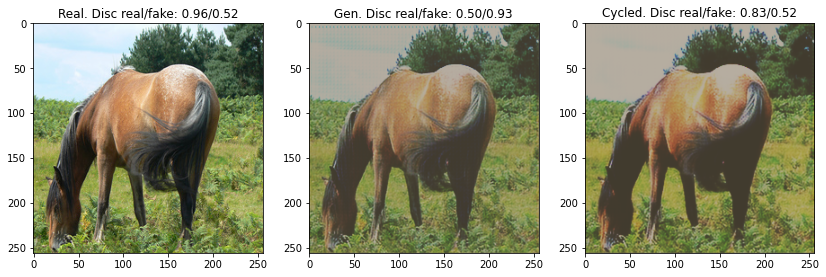

Epoch: 9. Total time of training is 4500.203482627869 sec


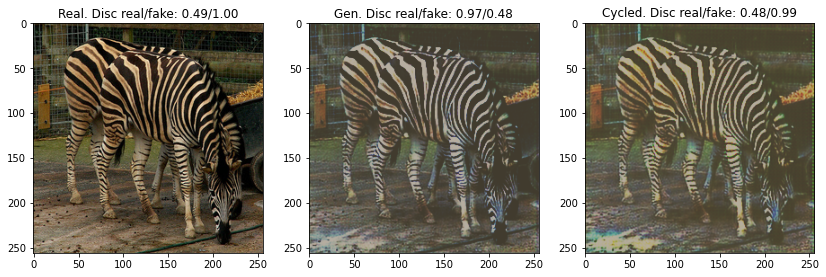

In [ ]:
runner.train(
    model=model,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    main_metric="g_AB_loss",
    num_epochs=200,
    check=False,
    verbose=False,
    logdir=logdir,
)

# Model infer


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, generated: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(generated)
    plt.title(f"Generated: {name}")

In [ ]:
num_workers: int = 4

# Creates our valid dataset
np_A_images = A_IMGS;
np_B_images = B_IMGS;

test_dataset = GanDataset(
  A_images = np_A_images,
  B_images = np_B_images,
  transforms = valid_transforms
)

# Catalyst uses normal torch.data.DataLoader
infer_loader = DataLoader(
  test_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=num_workers,
  drop_last=True,
)

iter_dataset = iter(infer_loader)
#iter_generated = iter(runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth"))

#print(image.shape, gen_image.shape)
#print(type(image), type(gen_image))

In [ ]:
images = next(iter_dataset)['image']
gen_images = g_AB(images.cuda())
#gen_images = utils.tensor_to_ndimage(g_AB(images)[0].detach())
i = 0
# runner.batch_metrics

In [ ]:
image = utils.tensor_to_ndimage(images[i])
gen_image = gen_images[i].cpu().detach()
gen_image = utils.tensor_to_ndimage(gen_image)
print(image.shape, gen_image.shape)


test_D_A = runner.model['d_A'](images[i].unsqueeze(0).cuda())
test_D_B = runner.model['d_B'](images[i].unsqueeze(0).cuda())
print("D_A: {:.2f} D_B: {:.2f}".format(torch.mean(test_D_A), torch.mean(test_D_B)))
if (torch.mean(test_D_A) > 0.8):
  print ("ITS HORSE!! prob: {:.2f}".format(torch.mean(test_D_A)))

if (torch.mean(test_D_B) > 0.8):
  print ("ITS ZEBRA!! prob: {:.2f}".format(torch.mean(test_D_B) ))
  
show_examples(name="", image=image, generated=gen_image)
#i += 1